In [1]:
import pandas as pd
from sklearn import preprocessing, metrics
import numpy as np
import lightgbm as lgb

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.style.use('seaborn-pastel')
plt.rcParams["figure.figsize"] = (16*0.8, 9*0.8)

In [2]:
calendar = pd.read_csv("../data/calendar.csv")
sales_train_evaluation = pd.read_csv("../data/sales_train_evaluation.csv")
sales_train_validation = pd.read_csv("../data/sales_train_validation.csv")
sell_prices = pd.read_csv("../data/sell_prices.csv")
submission = pd.read_csv("../data/sample_submission.csv")

In [3]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [4]:
print(sales_train_validation.shape)
sales_train_validation.head()

(30490, 1919)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [3]:
sales_train_validation["total"] = sales_train_validation.iloc[:,6:].sum(axis=1)

In [4]:
cat_and_state = sales_train_validation[["cat_id","state_id","total"]].groupby(by=["cat_id","state_id"]).agg('sum').reset_index()

In [5]:
cat_and_state

,cat_id,state_id,total
0,FOODS,CA,19196302
1,FOODS,TX,12956421
2,FOODS,WI,12937216
3,HOBBIES,CA,3039883
4,HOBBIES,TX,1592339
5,HOBBIES,WI,1492578
6,HOUSEHOLD,CA,6439362
7,HOUSEHOLD,TX,4350246
8,HOUSEHOLD,WI,3691062


In [6]:
cat_and_state[cat_and_state['cat_id'] == 'HOUSEHOLD'].iloc[:,-1].values.tolist()

[6439362, 4350246, 3691062]

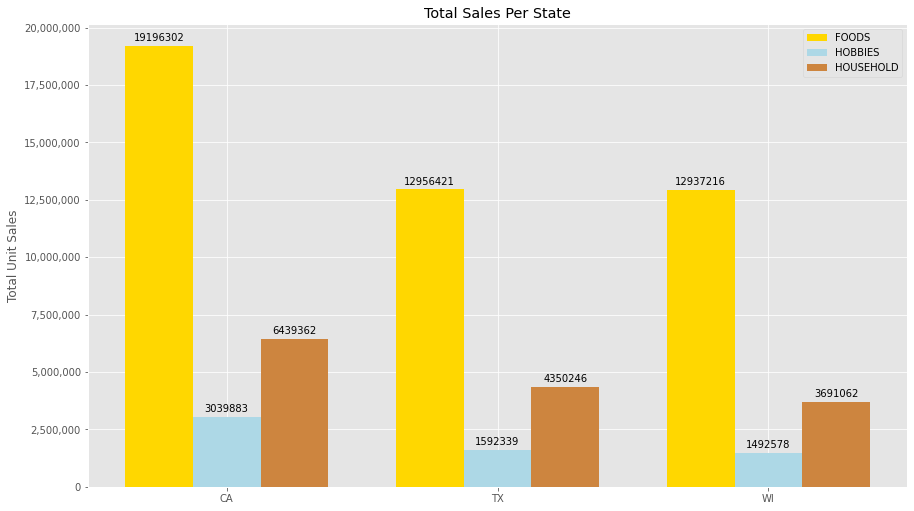

In [8]:
plt.style.use('ggplot')

plt.rcParams["figure.figsize"] = (16*0.8, 9*0.8)

labels = ['CA', 'TX', 'WI']
foods_sum = cat_and_state[cat_and_state['cat_id'] == 'FOODS'].iloc[:,-1].values.tolist()
hobbies_sum = cat_and_state[cat_and_state['cat_id'] == 'HOBBIES'].iloc[:,-1].values.tolist()
household_sum = cat_and_state[cat_and_state['cat_id'] == 'HOUSEHOLD'].iloc[:,-1].values.tolist()

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, foods_sum, width, label='FOODS', color='gold')
rects2 = ax.bar(x, hobbies_sum, width, label='HOBBIES', color='lightblue')
rects3 = ax.bar(x + width, household_sum, width, label='HOUSEHOLD', color='#CD853F')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total Unit Sales')
ax.set_title('Total Sales Per State')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()


plt.show()

In [9]:
sales_by_stores = sales_train_validation[["store_id","total"]].groupby(by=["store_id"]).sum().reset_index()

In [10]:
sales_by_stores.store_id.values[4:7]

array(['TX_1', 'TX_2', 'TX_3'], dtype=object)

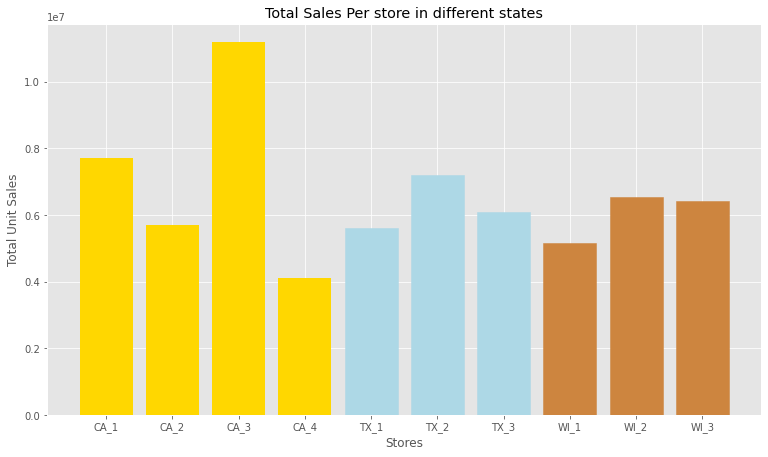

In [11]:
x = sales_by_stores.store_id.values
sales = sales_by_stores.total.values

x_pos = [i for i, _ in enumerate(x)]

barlist=plt.bar(x_pos, sales, color='gold')
barlist[4].set_color('lightblue')
barlist[5].set_color('lightblue')
barlist[6].set_color('lightblue')
barlist[7].set_color('#CD853F')
barlist[8].set_color('#CD853F')
barlist[9].set_color('#CD853F')

plt.xlabel("Stores")
plt.ylabel("Total Unit Sales")
plt.title("Total Sales Per store in different states")

plt.xticks(x_pos, x)

plt.show()

In [12]:
dept_item = sales_train_validation[["dept_id","item_id"]].groupby(by=["dept_id","item_id"]).size().reset_index()
item_per_dept = dept_item[["dept_id","item_id"]].groupby(by=["dept_id"]).size().reset_index()
item_per_dept.columns = ['dept_id','item_count']
item_per_dept

,dept_id,item_count
0,FOODS_1,216
1,FOODS_2,398
2,FOODS_3,823
3,HOBBIES_1,416
4,HOBBIES_2,149
5,HOUSEHOLD_1,532
6,HOUSEHOLD_2,515


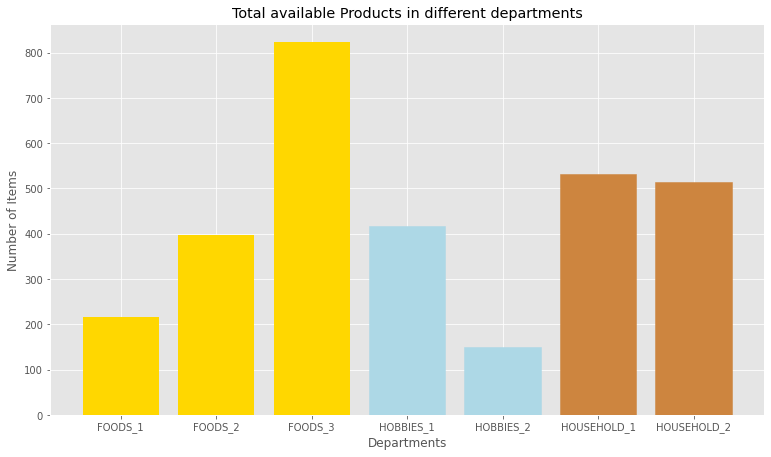

In [13]:
x = item_per_dept.dept_id.values
sales = item_per_dept.item_count.values

x_pos = [i for i, _ in enumerate(x)]

barlist=plt.bar(x_pos, sales, color='gold')
barlist[3].set_color('lightblue')
barlist[4].set_color('lightblue')
barlist[5].set_color('#CD853F')
barlist[6].set_color('#CD853F')
#barlist[7].set_color('#CD853F')

plt.xlabel("Departments")
plt.ylabel("Number of Items")
plt.title("Total available Products in different departments")
autolabel(barlist)

plt.xticks(x_pos, x)

plt.show()

In [24]:
tmp_1 = sales_train_validation[["item_id","dept_id","store_id","state_id","total"]].groupby(by=["item_id","dept_id","store_id","state_id"]).sum().reset_index()
tmp_1.head()

,item_id,dept_id,store_id,state_id,total
0,FOODS_1_001,FOODS_1,CA_1,CA,1503
1,FOODS_1_001,FOODS_1,CA_2,CA,2214
2,FOODS_1_001,FOODS_1,CA_3,CA,2302
3,FOODS_1_001,FOODS_1,CA_4,CA,688
4,FOODS_1_001,FOODS_1,TX_1,TX,1119


In [15]:
tmp_2 = sell_prices[["item_id","store_id","sell_price"]].groupby(by=["item_id","store_id"]).agg(["size","sum"]).reset_index()

In [25]:
df = pd.merge(tmp_1,tmp_2,on=["item_id","store_id"])
len(df)

30490

In [31]:
df.columns = ["item_id","dept_id","store_id","state_id","Total_Sales","Quantity","Total"]
df_group = df[["dept_id","state_id","Total_Sales","Quantity","Total"]].groupby(by=["dept_id","state_id"]).sum().reset_index()

In [67]:
def Average(df):
    q = df['Quantity']
    t = df['Total']
    s = df['Total_Sales']
    return s * t / q
df_group["Total_Income"] = df_group.apply(Average,axis=1)

In [68]:
df_group.head()

,dept_id,state_id,Total_Sales,Quantity,Total,Average,Total_Income
0,FOODS_1,CA,2365928,207291,682329.10,3.291648,7.787803e+06
1,FOODS_1,TX,1285632,159105,534587.85,3.359969,4.319684e+06
2,FOODS_1,WI,1436481,156818,548746.71,3.499258,5.026618e+06
3,FOODS_2,CA,2957744,312247,1285101.75,4.115658,1.217306e+07
4,FOODS_2,TX,2167147,269032,1074605.75,3.994342,8.656326e+06


In [45]:
df_group[df_group["state_id"] == "CA"].iloc[:,2].values.tolist()

[2365928, 2957744, 13872630, 2827183, 212700, 4885015, 1554347]

In [66]:
df_group_v2 = df[["dept_id","Quantity","Total"]].groupby(by=["dept_id"]).sum().reset_index()
def Average(df):
    q = df['Quantity']
    t = df['Total']
    return t/q
df_group_v2["Average"] = df_group_v2.apply(Average,axis=1)
df_group_v2

,dept_id,Quantity,Total,Average
0,FOODS_1,523214,1765663.66,3.374649
1,FOODS_2,823305,3362383.89,4.084008
2,FOODS_3,1835270,5216033.58,2.842107
3,HOBBIES_1,960337,5978851.16,6.225784
4,HOBBIES_2,323568,869364.77,2.686807
5,HOUSEHOLD_1,1160297,5868297.82,5.057583
6,HOUSEHOLD_2,1215130,7115264.14,5.855558


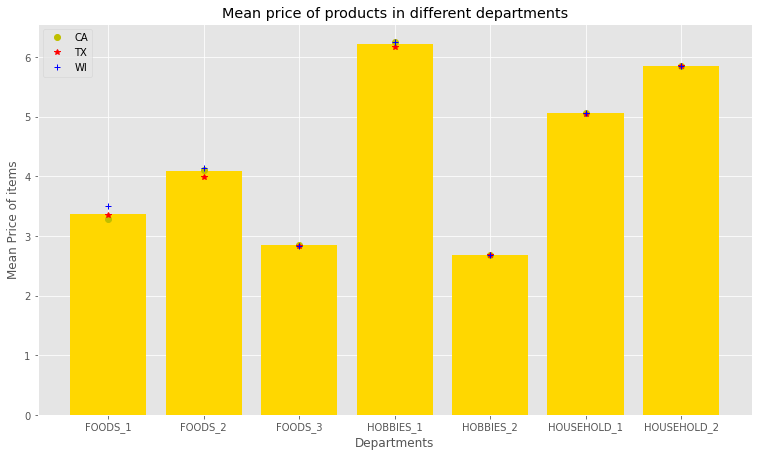

In [72]:
labels = df_group.dept_id.unique().tolist()

x = df_group_v2.dept_id.unique().tolist()
sales = df_group_v2.Average.values

x_pos = [i for i, _ in enumerate(x)]

barlist=plt.bar(x_pos, sales, color='gold')
CA_sum = df_group[df_group["state_id"] == "CA"].iloc[:,-2].values.tolist()
TX_sum = df_group[df_group["state_id"] == "TX"].iloc[:,-2].values.tolist()
WI_sum = df_group[df_group["state_id"] == "WI"].iloc[:,-2].values.tolist()

plt.xlabel("Departments")
plt.ylabel("Mean Price of items")
plt.title("Mean price of products in different departments")

plt.plot(labels, CA_sum, 'yo', label = 'CA')
plt.plot(labels, TX_sum, 'r*', label = 'TX')
plt.plot(labels, WI_sum, 'b+', label = 'WI')

plt.legend()
plt.show()

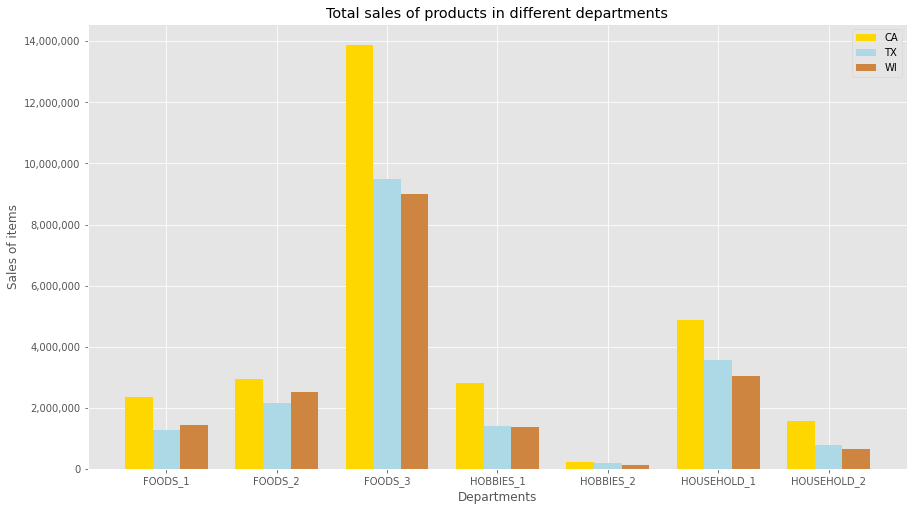

In [44]:
labels = df_group.dept_id.unique().tolist()
CA_sum = df_group[df_group["state_id"] == "CA"].iloc[:,2].values.tolist()
TX_sum = df_group[df_group["state_id"] == "TX"].iloc[:,2].values.tolist()
WI_sum = df_group[df_group["state_id"] == "WI"].iloc[:,2].values.tolist()

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, CA_sum, width, label='CA', color='gold')
rects2 = ax.bar(x, TX_sum, width, label='TX', color='lightblue')
rects3 = ax.bar(x + width, WI_sum, width, label='WI', color='#CD853F')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Departments')
ax.set_ylabel('Sales of items')
ax.set_title('Total sales of products in different departments')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))

fig.tight_layout()
plt.show()

In [14]:
sales_train_validation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [3]:
df = sales_train_validation.iloc[:,3:].groupby(by=["cat_id","store_id","state_id"]).sum().reset_index()

In [4]:
df_melt = pd.melt(df, id_vars=["cat_id","store_id","state_id"], value_vars=df.columns[3:].tolist())
df_melt.columns = ["cat_id","store_id","state_id","d","sales"]
df_melt.tail()

,cat_id,store_id,state_id,d,sales
57385,HOUSEHOLD,TX_2,TX,d_1913,1026
57386,HOUSEHOLD,TX_3,TX,d_1913,1055
57387,HOUSEHOLD,WI_1,WI,d_1913,983
57388,HOUSEHOLD,WI_2,WI,d_1913,1233
57389,HOUSEHOLD,WI_3,WI,d_1913,967


In [5]:
df_merge = pd.merge(df_melt,calendar,how='left')
df_merge.tail()

,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
57385,HOUSEHOLD,TX_2,TX,d_1913,1026,2016-04-24,11613,Sunday,2,4,2016,NaN,NaN,NaN,NaN,0,0,0
57386,HOUSEHOLD,TX_3,TX,d_1913,1055,2016-04-24,11613,Sunday,2,4,2016,NaN,NaN,NaN,NaN,0,0,0
57387,HOUSEHOLD,WI_1,WI,d_1913,983,2016-04-24,11613,Sunday,2,4,2016,NaN,NaN,NaN,NaN,0,0,0
57388,HOUSEHOLD,WI_2,WI,d_1913,1233,2016-04-24,11613,Sunday,2,4,2016,NaN,NaN,NaN,NaN,0,0,0
57389,HOUSEHOLD,WI_3,WI,d_1913,967,2016-04-24,11613,Sunday,2,4,2016,NaN,NaN,NaN,NaN,0,0,0


In [6]:
cat_n_state = df_merge[["date", "state_id", "cat_id","sales"]].groupby(["date", "state_id", "cat_id"]).sum().reset_index()
cat_n_state.head()

,date,state_id,cat_id,sales
0,2011-01-29,CA,FOODS,10101
1,2011-01-29,CA,HOBBIES,1802
2,2011-01-29,CA,HOUSEHOLD,2292
3,2011-01-29,TX,FOODS,6853
4,2011-01-29,TX,HOBBIES,879


In [7]:
from datetime import datetime

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.


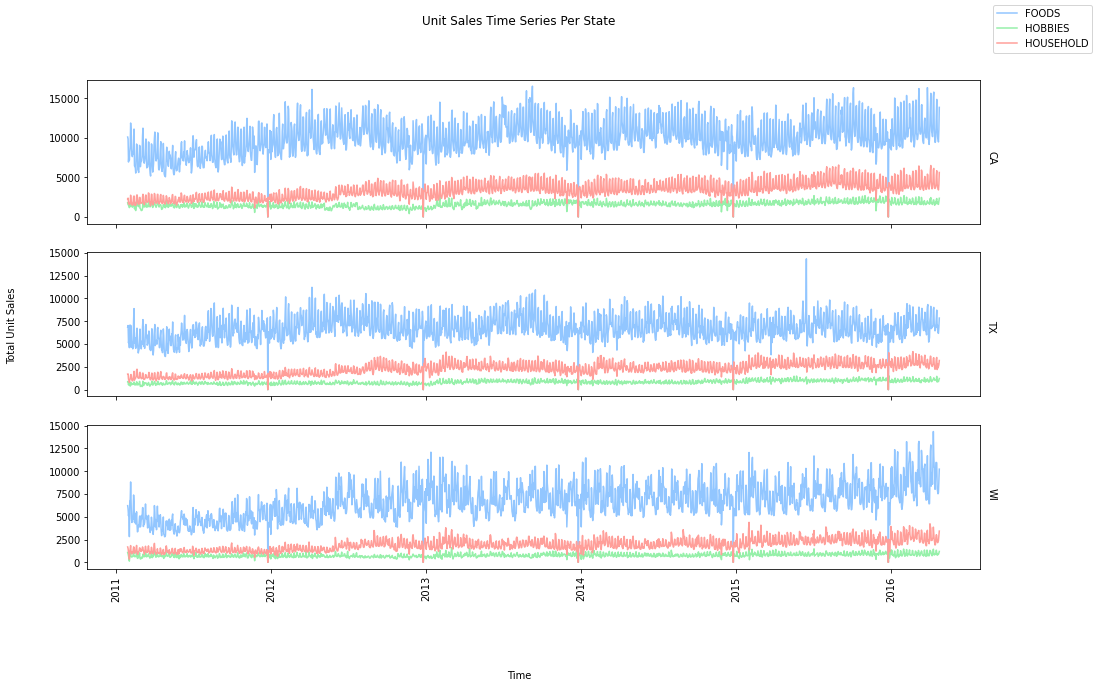

In [19]:
plt.style.use('seaborn-pastel')

plt.rcParams["figure.figsize"] = (16, 9)

fig, axs = plt.subplots(3, sharex=True)
fig.suptitle('Unit Sales Time Series Per State')
# Set common labels
fig.text(0.5, -0.04, 'Time', ha='center', va='center')
fig.text(0.06, 0.5, 'Total Unit Sales', ha='center', va='center', rotation='vertical')

fig.text(0.91, 0.76, 'CA', ha='center', va='center', rotation=270)
fig.text(0.91, 0.50, 'TX', ha='center', va='center', rotation=270)
fig.text(0.91, 0.24, 'WI', ha='center', va='center', rotation=270)



n = 1912
x = cat_n_state[(cat_n_state["state_id"] == "CA") & (cat_n_state["cat_id"] == "FOODS")].date[:n]
arr = []
for i in x:
    #print(i)
    #print(datetime.strptime(i, "%Y-%m-%d"))
    arr.append(datetime.strptime(i, "%Y-%m-%d"))
plt.xticks(rotation=90)

axs[0].plot(arr, cat_n_state[(cat_n_state["state_id"] == "CA") & (cat_n_state["cat_id"] == "FOODS")].sales[:n]
            , label="FOODS")
axs[0].plot(arr, cat_n_state[(cat_n_state["state_id"] == "CA") & (cat_n_state["cat_id"] == "HOBBIES")].sales[:n]
            , label="HOBBIES")
axs[0].plot(arr, cat_n_state[(cat_n_state["state_id"] == "CA") & (cat_n_state["cat_id"] == "HOUSEHOLD")].sales[:n]
            , label="HOUSEHOLD")
axs[1].plot(arr, cat_n_state[(cat_n_state["state_id"] == "TX") & (cat_n_state["cat_id"] == "FOODS")].sales[:n])
axs[1].plot(arr, cat_n_state[(cat_n_state["state_id"] == "TX") & (cat_n_state["cat_id"] == "HOBBIES")].sales[:n])
axs[1].plot(arr, cat_n_state[(cat_n_state["state_id"] == "TX") & (cat_n_state["cat_id"] == "HOUSEHOLD")].sales[:n])
axs[2].plot(arr, cat_n_state[(cat_n_state["state_id"] == "WI") & (cat_n_state["cat_id"] == "FOODS")].sales[:n])
axs[2].plot(arr, cat_n_state[(cat_n_state["state_id"] == "WI") & (cat_n_state["cat_id"] == "HOBBIES")].sales[:n])
axs[2].plot(arr, cat_n_state[(cat_n_state["state_id"] == "WI") & (cat_n_state["cat_id"] == "HOUSEHOLD")].sales[:n])

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='best')

In [20]:
plt.rcParams["figure.figsize"] = (16*0.8, 9*0.8)

In [22]:
df_merge.tail()

,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
57385,HOUSEHOLD,TX_2,TX,d_1913,1026,2016-04-24,11613,Sunday,2,4,2016,NaN,NaN,NaN,NaN,0,0,0
57386,HOUSEHOLD,TX_3,TX,d_1913,1055,2016-04-24,11613,Sunday,2,4,2016,NaN,NaN,NaN,NaN,0,0,0
57387,HOUSEHOLD,WI_1,WI,d_1913,983,2016-04-24,11613,Sunday,2,4,2016,NaN,NaN,NaN,NaN,0,0,0
57388,HOUSEHOLD,WI_2,WI,d_1913,1233,2016-04-24,11613,Sunday,2,4,2016,NaN,NaN,NaN,NaN,0,0,0
57389,HOUSEHOLD,WI_3,WI,d_1913,967,2016-04-24,11613,Sunday,2,4,2016,NaN,NaN,NaN,NaN,0,0,0


In [25]:
state_month = df_merge[["state_id","year","month","sales"]].groupby(["state_id","year","month"]).sum().reset_index()
state_month.head()

,state_id,year,month,sales
0,CA,2011,1,38108
1,CA,2011,2,318101
2,CA,2011,3,339678
3,CA,2011,4,331004
4,CA,2011,5,321566


In [36]:
def yearmonth(df):
    year = df["year"]
    month = df["month"]
    return "{}-{:0>2}-01".format(year,month)

state_month["yearmonth"] = state_month.apply(yearmonth,axis=1)
state_month.tail()

,state_id,year,month,sales,yearmonth
187,WI,2015,12,340698,2015-12-01
188,WI,2016,1,368104,2016-01-01
189,WI,2016,2,379113,2016-02-01
190,WI,2016,3,393142,2016-03-01
191,WI,2016,4,330726,2016-04-01


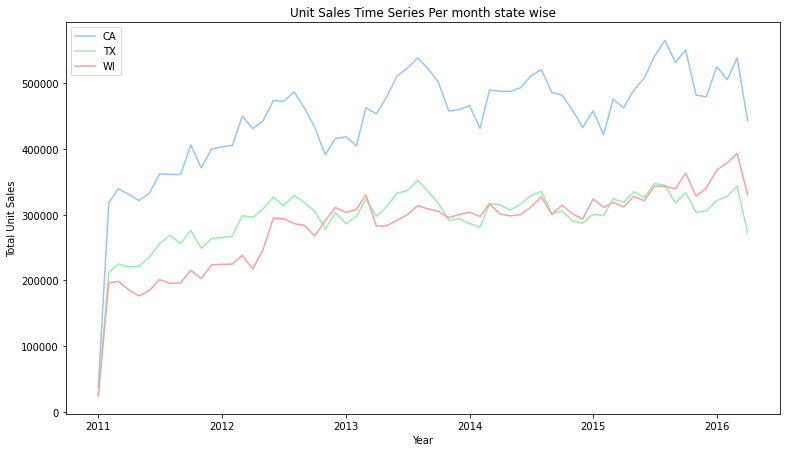

In [38]:
labels = state_month[state_month["state_id"]=="CA"].yearmonth

arr = []
for i in labels:
    #print(i)
    #print(datetime.strptime(i, "%Y-%m-%d"))
    arr.append(datetime.strptime(i, "%Y-%m-%d"))

sales_CA = state_month[state_month["state_id"]=="CA"].sales
sales_TX = state_month[state_month["state_id"]=="TX"].sales
sales_WI = state_month[state_month["state_id"]=="WI"].sales

plt.xlabel("Year")
plt.ylabel("Total Unit Sales")
plt.title("Unit Sales Time Series Per month state wise")

plt.plot(arr, sales_CA, label = 'CA')
plt.plot(arr, sales_TX, label = 'TX')
plt.plot(arr, sales_WI, label = 'WI')

plt.legend()
plt.show()

In [39]:
state_month.head()

,state_id,year,month,sales,yearmonth
0,CA,2011,1,38108,2011-01-01
1,CA,2011,2,318101,2011-02-01
2,CA,2011,3,339678,2011-03-01
3,CA,2011,4,331004,2011-04-01
4,CA,2011,5,321566,2011-05-01


In [43]:
state_month_v2 = state_month[["state_id","month","sales"]].groupby(["state_id","month"]).sum().reset_index()

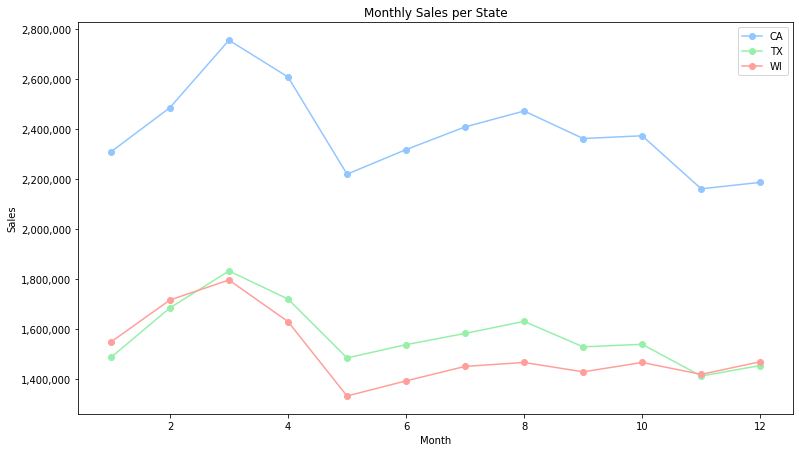

In [51]:
labels = np.arange(1,13)

sales_CA = state_month_v2[state_month_v2["state_id"]=="CA"].sales
sales_TX = state_month_v2[state_month_v2["state_id"]=="TX"].sales
sales_WI = state_month_v2[state_month_v2["state_id"]=="WI"].sales

fig, ax = plt.subplots()
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))

plt.xlabel("Month")
plt.ylabel("Sales")
plt.title("Monthly Sales per State")

ax.plot(labels, sales_CA, '-o', label = 'CA')
ax.plot(labels, sales_TX, '-o', label = 'TX')
ax.plot(labels, sales_WI, '-o', label = 'WI')

plt.legend()
plt.show()

In [6]:
weekly = df_merge[["state_id","weekday","sales"]].groupby(["state_id","weekday"]).sum().reset_index()
weekly.tail(7)

,state_id,weekday,sales
14,WI,Friday,2710498
15,WI,Monday,2367156
16,WI,Saturday,3218710
17,WI,Sunday,2911233
18,WI,Thursday,2321344
19,WI,Tuesday,2290901
20,WI,Wednesday,2301014


In [7]:
weekly.iloc[-7:,1].values

array(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'], dtype=object)

In [8]:
def weekdaynum(df):
    arr = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekday = df['weekday']
    return arr.index(weekday)+1

weekly["weekdaynum"] = weekly.apply(weekdaynum,axis=1)
weekly = weekly.sort_values(by=['weekdaynum'])
weekly.head(7)

,state_id,weekday,sales,weekdaynum
1,CA,Monday,3967465,1
15,WI,Monday,2367156,1
8,TX,Monday,2634239,1
5,CA,Tuesday,3614175,2
19,WI,Tuesday,2290901,2
12,TX,Tuesday,2385601,2
20,WI,Wednesday,2301014,3


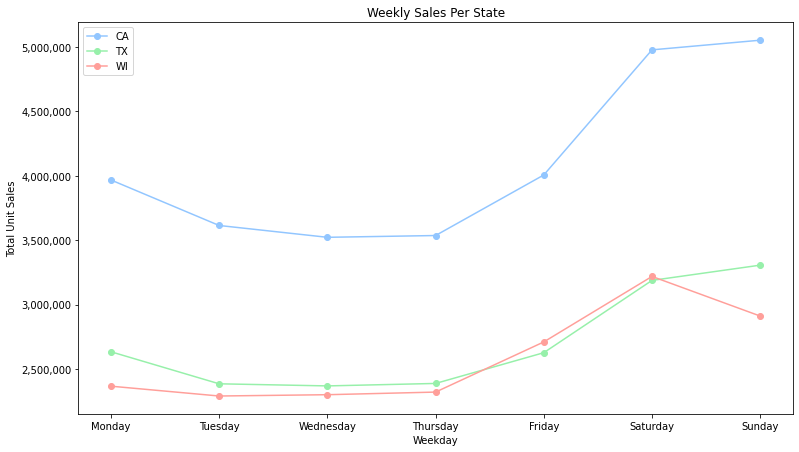

In [13]:
plt.rcParams["figure.figsize"] = (16*0.8, 9*0.8)
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

sales_CA = weekly[weekly["state_id"]=="CA"].sales
sales_TX = weekly[weekly["state_id"]=="TX"].sales
sales_WI = weekly[weekly["state_id"]=="WI"].sales

fig, ax = plt.subplots()
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))

plt.xlabel("Weekday")
plt.ylabel("Total Unit Sales")
plt.title("Weekly Sales Per State")

ax.plot(labels, sales_CA, '-o', label = 'CA')
ax.plot(labels, sales_TX, '-o', label = 'TX')
ax.plot(labels, sales_WI, '-o', label = 'WI')

plt.legend()
plt.show()

In [6]:
my_tmp = df_merge[["state_id","weekday","month","sales"]].groupby(["state_id","weekday","month"]).sum().reset_index()

In [7]:
table = pd.pivot_table(my_tmp, values='sales', index=['weekday'], columns=['month'], aggfunc=np.sum)
table.values

array([[ 785297,  805166,  875930,  856296,  763838,  746289,  800855,
         836389,  729346,  769570,  705891,  668827],
       [ 699629,  823590,  845361,  791815,  667727,  754775,  733643,
         748332,  765193,  718843,  666887,  753065],
       [ 997833, 1041717, 1136936, 1044592,  859250,  902349,  826864,
         984441,  905580,  936699,  880504,  867084],
       [ 929319, 1012259, 1152665, 1040798,  816546,  905140,  884666,
         963438,  952934,  889029,  904110,  818722],
       [ 675517,  734972,  806011,  718085,  667089,  643164,  722279,
         698013,  639712,  700701,  578785,  661639],
       [ 628697,  722176,  807303,  761470,  635392,  661240,  739307,
         658649,  688428,  673914,  624137,  689964],
       [ 629219,  749709,  763004,  747955,  628255,  637255,  736361,
         682468,  640696,  691833,  633310,  652671]])

In [8]:
weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
table = table.reindex(weekday)
table

month,1,2,3,4,5,6,7,8,9,10,11,12
weekday,,,,,,,,,,,,
Monday,699629,823590,845361,791815,667727,754775,733643,748332,765193,718843,666887,753065
Tuesday,628697,722176,807303,761470,635392,661240,739307,658649,688428,673914,624137,689964
Wednesday,629219,749709,763004,747955,628255,637255,736361,682468,640696,691833,633310,652671
Thursday,675517,734972,806011,718085,667089,643164,722279,698013,639712,700701,578785,661639
Friday,785297,805166,875930,856296,763838,746289,800855,836389,729346,769570,705891,668827
Saturday,997833,1041717,1136936,1044592,859250,902349,826864,984441,905580,936699,880504,867084
Sunday,929319,1012259,1152665,1040798,816546,905140,884666,963438,952934,889029,904110,818722


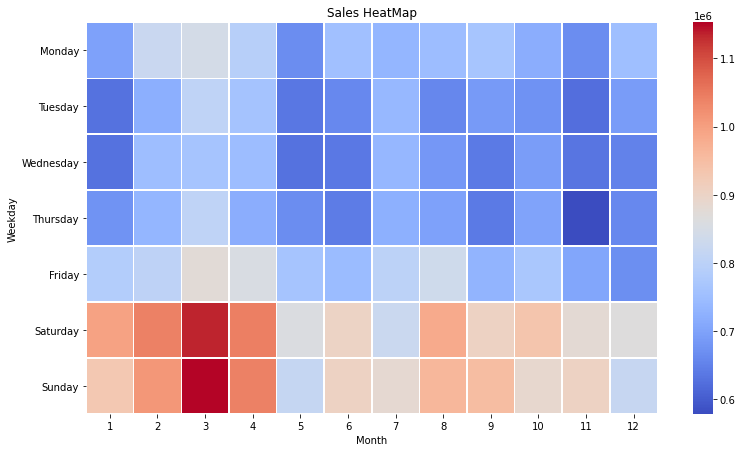

In [16]:
plt.rcParams["figure.figsize"] = (16*0.8, 9*0.8)
weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months = np.arange(1,13)
ax = sns.heatmap(table.values, linewidth=0.5, xticklabels=months, yticklabels=weekday, cmap='coolwarm')
ax.set_title("Sales HeatMap")
ax.set_ylabel('Weekday')
ax.set_xlabel('Month')

plt.show()

In [49]:
tmp = pd.concat([df_merge[["cat_id","event_name_1","sales"]].dropna().rename(columns={'event_name_1': 'event_name'}),
                df_merge[["cat_id","event_name_2","sales"]].dropna().rename(columns={'event_name_2': 'event_name'})])
event_sales = tmp.groupby(["cat_id","event_name"]).sum().reset_index()
event_sales.tail()

,cat_id,event_name,sales
85,HOUSEHOLD,StPatricksDay,45212
86,HOUSEHOLD,SuperBowl,48602
87,HOUSEHOLD,Thanksgiving,20044
88,HOUSEHOLD,ValentinesDay,42380
89,HOUSEHOLD,VeteransDay,35714


In [72]:
event_order = event_sales[["event_name","sales"]].groupby('event_name').sum().reset_index().sort_values(by=['sales']).event_name.values

In [73]:
food = []
hobbies = []
household = []

for i in event_order:
    food.append(event_sales[event_sales["event_name"] == i].sales.values[0])
    hobbies.append(event_sales[event_sales["event_name"] == i].sales.values[1])
    household.append(event_sales[event_sales["event_name"] == i].sales.values[2])

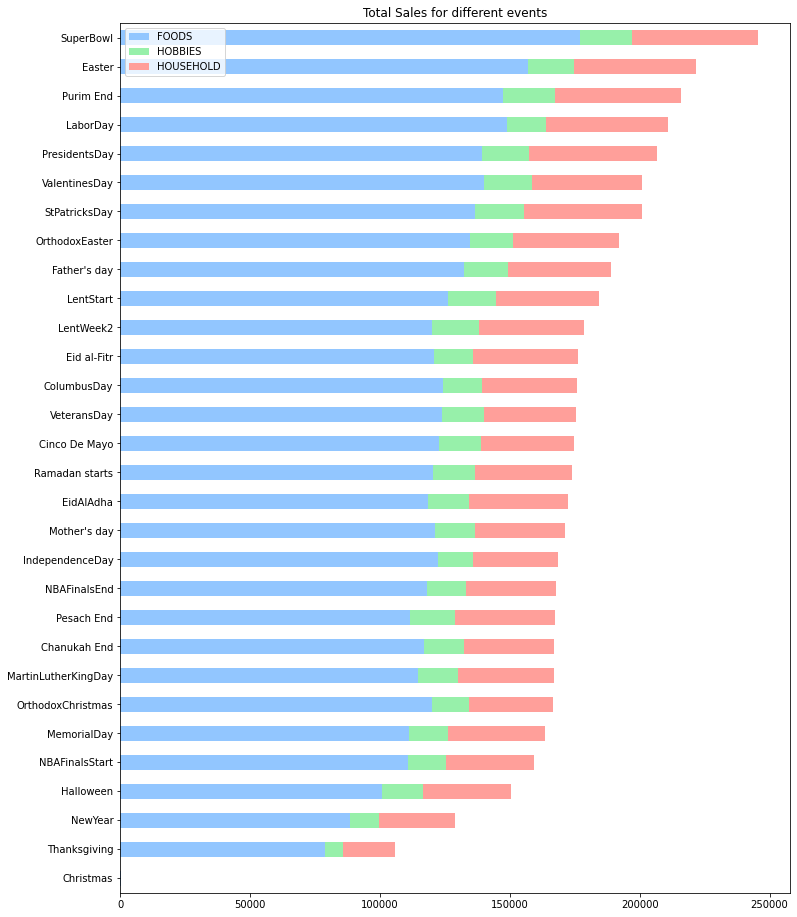

In [75]:
plt.rcParams["figure.figsize"] = (12, 16)

df = pd.DataFrame({'FOODS' : food,'HOBBIES' : hobbies, 'HOUSEHOLD' : household})
ax = df.plot.barh(stacked=True);
#ax.set_yticks(range(5))
ax.set_yticklabels(event_order)


ax.set_title("Total Sales for different events")
ax.legend(loc='upper left')